# 使用HOG、滑動視窗、影像金字塔及SVM進行物件偵測

In [3]:
!pip install -U scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.8 MB 1.9 MB/s eta 0:00:07
    --------------------------------------- 0.3/12.8 MB 3.1 MB/s eta 0:00:05
   - -------------------------------------- 0.6/12.8 MB 4.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/12.8 MB 6.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/12.8 MB 7.2 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/12.8 MB 8.4 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.8 MB 9.2 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.8 MB 9.4 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.8 MB 9.6 MB/s eta 0:00:01
   -------------- ------------------------- 4.7/12.8 MB 10.1 MB/s eta 0:00:01
   ---------------- ----------------------- 5.1/12.8 MB 9.9 MB/s eta 0:00:01
   ------------------ --------------------- 5.8/12.8 MB 10.3 MB/s eta 0:00:01
   -

In [4]:
# Scikit-Image 的範例
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
#skimage 可用於圖像的讀取輸出、分割、轉換
from skimage.feature import hog
from skimage import data, exposure

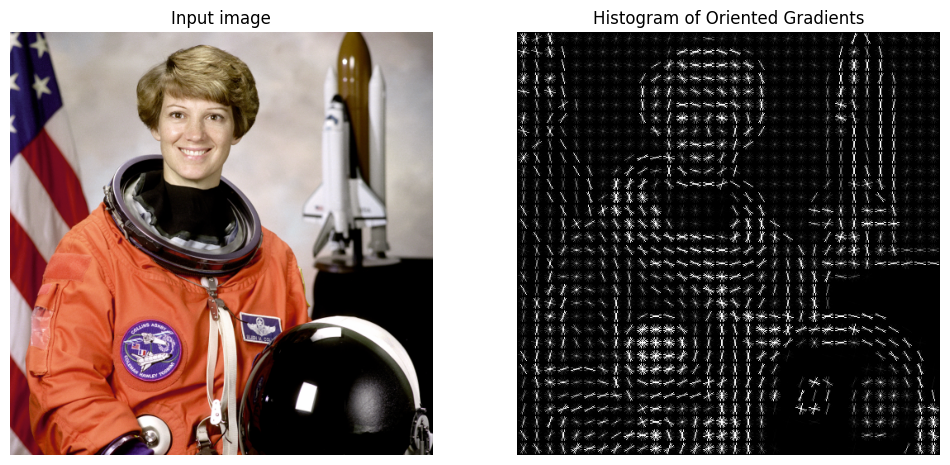

In [7]:
# 測試skimage內建的測試圖片
'''
astronaut：太空人圖片  / coffee：一杯咖啡圖片
lena：lena美女圖片  / camera：拿相機的人圖片
coins：硬幣圖片  /  moon：月亮圖片
checkerboard：棋盤圖片  / horse：馬圖片
page：書頁圖片  / chelsea：小貓圖片
hubble_deep_field：星空圖片  / text：文字圖片
clock：時鐘圖片  / immunohistochemistry：結腸圖片
'''
image = data.astronaut()

# 取得圖片的 hog
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True,channel_axis=-1)#, multichannel=True

# 原圖與 hog圖比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# 調整對比，讓顯示比較清楚
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [8]:
# 收集正樣本 (positive set)
# 使用 scikit-learn 的人臉資料集
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

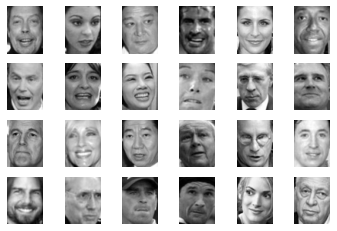

In [ ]:
# 顯示正樣本部份圖片
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

In [ ]:
# 收集負樣本 (negative set)
# 使用 Scikit-Image 的非人臉資料
from skimage import data, transform, color

imgs_to_use0 = [ 'text', 'coins', 'moon', 'page', 'clock','horse'] # 灰階
imgs_to_use1 = ['hubble_deep_field', 'coffee','chelsea'] # 彩色

# for i in imgs_to_use:
#     sample = getattr(data, i)()
#     # color.rgb2gray(sample)
#     print(i, sample.shape)

images0 = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use1]
images1 = [getattr(data, name)() for name in imgs_to_use0]

images = (images0 + images1)
len(images)

9

In [ ]:
# 將負樣本轉換為不同的尺寸
from sklearn.feature_extraction.image import PatchExtractor

# 轉換為不同的尺寸
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    # PatchExtractor：產生不同尺寸的圖像
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

# 產生 27000 筆圖像
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(27000, 62, 47)

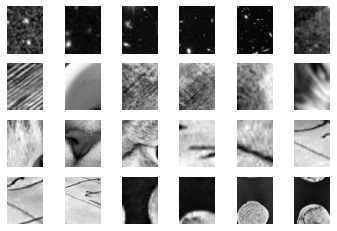

In [ ]:
# 顯示部份負樣本
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[600 * i], cmap='gray')
    axi.axis('off')

In [ ]:
# 合併正樣本與負樣本
from skimage import feature   # To use skimage.feature.hog()
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
# 使用 SVM 作二分類的訓練
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# C為矯正過度擬合強度的倒數，使用 GridSearchCV 尋求最佳參數值
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9884423234658116

In [ ]:
# C 最佳參數值
grid.best_params_

{'C': 1.0}

In [ ]:
# 依最佳參數值再訓練一次
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

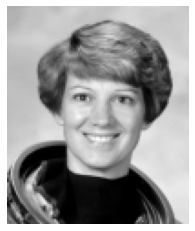

In [ ]:
# 取新圖像測試
test_img = data.astronaut()
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [ ]:
# 滑動視窗函數
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [ ]:
# 使用滑動視窗計算每一視窗的 Hog
indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])

# 辨識每一視窗
labels = model.predict(patches_hog)
labels.sum() # 偵測到的總數

51.0

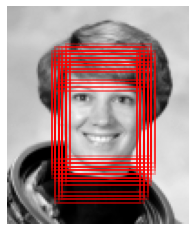

In [ ]:
# 將每一個偵測到的視窗顯示出來
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 取得左上角座標
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

# 顯示
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [ ]:
patches_hog.shape

(551, 1215)

In [ ]:
candidate_patches = patches_hog[labels == 1]
candidate_patches.shape

(51, 1215)

##  Non-Maximum Suppression演算法
#### https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [ ]:
# Non-Maximum Suppression演算法 by Felzenszwalb et al.
# boxes：所有候選的視窗，overlapThresh：視窗重疊的比例門檻
def non_max_suppression_slow(boxes, overlapThresh=0.5):
    if len(boxes) == 0:
        return []

    pick = []        # 儲存篩選的結果
    x1 = boxes[:,0]  # 取得候選的視窗的左/上/右/下 座標
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # 計算候選視窗的面積
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)   # 依視窗的底Y座標排序

    # 比對重疊比例
    while len(idxs) > 0:
        # 最後一筆
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # 比對最後一筆與其他視窗重疊的比例
        for pos in range(0, last):
            j = idxs[pos]

            # 取得所有視窗的涵蓋範圍
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # 計算重疊比例
            overlap = float(w * h) / area[j]

            # 如果大於門檻值，則儲存起來
            if overlap > overlapThresh:
                suppress.append(pos)

        # 刪除合格的視窗，繼續比對
        idxs = np.delete(idxs, suppress)

    # 傳回合格的視窗
    return boxes[pick]

28 46 47 62
26 26 47 62


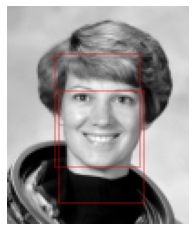

In [ ]:
# 使用 Non-Maximum Suppression演算法，剔除多餘的視窗。
candidate_boxes = []
for i, j in indices[labels == 1]:
    candidate_boxes.append([j, i, Nj, Ni])
final_boxes = non_max_suppression_slow(np.array(candidate_boxes).reshape(-1, 4))

# 將每一個合格的視窗顯示出來
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 顯示
for i, j, Ni, Nj in final_boxes:
    print(i, j, Ni, Nj)
    ax.add_patch(plt.Rectangle((i, j), Ni, Nj, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))